# 1. Labeling Function:
**For your analysis, you may focus on a subset of the 54 classes provided.**

In [12]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import umap 
from sklearn.manifold import  TSNE

In [13]:
PATH_TO_DATASET = '../MLPC2025_classification'
METADATA_CSV = os.path.join(PATH_TO_DATASET, "metadata.csv")
ANNOTATIONS_CSV = os.path.join(PATH_TO_DATASET, "annotations.csv")
AUDIO_FEATURE_FOLDER = os.path.join(PATH_TO_DATASET, "audio_features")

In [14]:
an_df = pd.read_csv("annotations.csv")
meta_df = pd.read_csv("metadata.csv")
an_df.head(5)

,task_id,filename,annotator,text,onset,offset,time,original_caption,categories
0,161976549,117126.mp3,1145579747015607221221744067969991550764671773...,An alarm is ringing loudly and repeatedly nearby.,0.000000,10.503064,345.033,Raw loud alarm sound repeatedly ringing nearby,['Alarm']
1,161976549,117126.mp3,1145579747015607221221744067969991550764671773...,An alarm is ringing repeatedly nearby.,12.514616,23.048000,345.033,Clean alarm sound repeatedly ringing nearby,['Alarm']
2,161976550,118234.mp3,5022633589939139634134314703519782680423201448...,An alarm clock is beeping continuously.,0.000000,13.414880,919.016,Alarm clock beeping continuesly,"['Alarm', 'Beep/Bleep']"
3,161976550,118234.mp3,5022633589939139634134314703519782680423201448...,An alarm clock is beeping continuously.,15.134252,28.492000,919.016,Alarm clock beeping continuesly,"['Alarm', 'Beep/Bleep']"
4,161976551,119173.mp3,8105077500224920444298835829881210427871190692...,A car alarm sounds loudly in a steady pattern.,0.000000,20.065604,2162.620,a car alarm sounds loudly in a steady pattern ...,"['Alarm', 'Car']"


In [15]:
import ast
import re

# Clean and standardize labels in one step
an_df["labels"] = (
    an_df["categories"]
    .apply(lambda x: ', '.join(sorted(set(
        # Remove quotes/whitespace and convert to lowercase
        re.sub(r"[\'\",]", "", label.strip()).lower()
        for label in ast.literal_eval(x)
        # Optional: Add quick replacements here
        #.replace("Beep/Bleep", "beep")
        #.replace("Sheep/Goat", "sheep")
    ))))
)

# Show results
print(an_df["labels"].value_counts().head())

labels
bird chirp    2437
speech        2284
dog bark      1374
wind           860
car            816
Name: count, dtype: int64


(a) Assess how accurately the applied labeling functions capture the intended classes.

Do the mapped classes correspond well to the free-text annotations?

Are the labeled events clearly audible within the indicated time regions?

In [16]:
count = 0
for c, a in zip(an_df["categories"], an_df["text"]):
    c = c.strip("[]' ,")
    if c.lower() in a:
        count += 1
print(count)
print(f"Label accuracy: {count / len(an_df):.2f}")

11197
Label accuracy: 0.41


In [21]:
import re
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Categories list
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

# Normalized and expanded sound mapping with unified Beep/Bleep
sound_mapping = {
    'Airplane': ['airplane', 'jet', 'plane', 'aircraft'],
    'Alarm': ['alarm', 'siren', 'alert'],
    'Beep/Bleep': ['beep', 'bleep', 'blip'],
    'Bell': ['bell', 'chime', 'ding'],
    'Bicycle': ['bicycle', 'bike', 'pedal'],
    'Bird Chirp': ['chirp', 'tweet', 'birdsong', 'bird call', 'singing bird', 'bird'],
    'Bus': ['bus', 'coach'],
    'Car': ['car', 'auto', 'vehicle'],
    'Cat Meow': ['meow', 'mew', 'cat sound', 'cat'],
    'Chainsaw': ['chainsaw', 'sawing'],
    'Clapping': ['clap', 'applause'],
    'Cough': ['cough', 'hack', 'throat clear'],
    'Cow Moo': ['moo', 'cow sound', 'cow'],
    'Cowbell': ['cowbell'],
    'Crying': ['cry', 'sob', 'wail'],
    'Dog Bark': ['bark', 'woof', 'arf', 'dog sound', 'dog'],
    'Doorbell': ['doorbell', 'chime'],
    'Drip': ['drip', 'droplet', 'dripping'],
    'Drums': ['drum', 'drumming', 'bongo'],
    'Fire': ['fire', 'crackle', 'burning'],
    'Footsteps': ['footstep', 'walking', 'steps'],
    'Guitar': ['guitar', 'strumming', 'plucking'],
    'Hammer': ['hammer', 'hammering'],
    'Helicopter': ['helicopter', 'chopper'],
    'Hiccup': ['hiccup', 'hiccough'],
    'Horn Honk': ['honk', 'horn blast', 'car horn', 'truck horn', 'klaxon', 'horn'],
    'Horse Neigh': ['neigh', 'whinny', 'horse'],
    'Insect Buzz': ['buzz', 'insect sound', 'insect'],
    'Jackhammer': ['jackhammer', 'pneumatic drill'],
    'Laughter': ['laugh', 'giggle', 'chuckle', 'ha ha'],
    'Lawn Mower': ['lawn mower', 'mower'],
    'Motorcycle': ['motorcycle', 'bike', 'motorbike'],
    'Piano': ['piano', 'keys', 'keyboard'],
    'Pig Oink': ['oink', 'snort', 'pig'],
    'Power Drill': ['power drill', 'drilling'],
    'Power Saw': ['power saw', 'saw'],
    'Rain': ['rain', 'raindrop', 'storm'],
    'Rooster Crow': ['rooster', 'cock-a-doodle-doo'],
    'Saxophone': ['saxophone', 'sax'],
    'Sewing Machine': ['sewing machine'],
    'Sheep/Goat Bleat': ['bleat', 'baa', 'sheep', 'goat'],
    'Ship/Boat': ['ship', 'boat', 'vessel', 'watercraft'],
    'Shout': ['shout', 'yell', 'scream'],
    'Singing': ['sing', 'song', 'melody'],
    'Siren': ['siren', 'wailing'],
    'Sneeze': ['sneeze', 'achoo', 'sniffle'],
    'Snoring': ['snore', 'snoring'],
    'Speech': ['talking', 'conversation', 'voice', 'dialogue', 'speaking'],
    'Stream/River': ['stream', 'brook', 'creek', 'running water', 'river'],
    'Thunder': ['thunder', 'rumble'],
    'Train': ['train', 'locomotive'],
    'Truck': ['truck', 'lorry'],
    'Trumpet': ['trumpet', 'horn'],
    'Vacuum Cleaner': ['vacuum', 'hoover'],
    'Violin': ['violin', 'fiddle'],
    'Washing Machine': ['washing machine', 'washer'],
    'Waves': ['wave', 'ocean wave', 'sea'],
    'Wind': ['wind', 'breeze', 'gust']
}

# Expanded context word associations
context_words = {
    'Beep/Bleep': ['alarm', 'electronic', 'device', 'signal', 'warning'],
    'Horn Honk': ['car', 'truck', 'vehicle', 'road', 'traffic'],
    'Bird Chirp': ['tree', 'outside', 'nature', 'forest', 'park'],
    'Dog Bark': ['pet', 'canine', 'animal', 'yard', 'leash'],
    'Cat Meow': ['feline', 'pet', 'animal', 'whiskers'],
    'Cow Moo': ['farm', 'barn', 'field'],
    'Sheep/Goat Bleat': ['pasture', 'farm', 'animal'],
    'Pig Oink': ['mud', 'farm', 'snout'],
    'Crying': ['baby', 'tears', 'emotion'],
    'Shout': ['yelling', 'angry', 'voice'],
    'Drip': ['sink', 'leak', 'faucet'],
    'Footsteps': ['hallway', 'stairs', 'walking'],
    'Lawn Mower': ['grass', 'cutting', 'yard'],
    'Motorcycle': ['bike', 'engine', 'helmet'],
    'Rain': ['storm', 'weather', 'sky'],
    'Rooster Crow': ['morning', 'dawn', 'barn'],
    'Stream/River': ['creek', 'nature', 'water'],
    'Waves': ['ocean', 'sea', 'beach'],
    'Ship/Boat': ['dock', 'harbor', 'sail'],
    'Washing Machine': ['laundry', 'clothes', 'spin'],
    'Vacuum Cleaner': ['carpet', 'cleaning', 'suction'],
    'Sewing Machine': ['fabric', 'needle', 'thread'],
    'Insect Buzz': ['bug', 'fly', 'mosquito'],
    'Power Drill': ['tool', 'build', 'hole'],
    'Power Saw': ['cutting', 'wood', 'tool'],
    'Sneeze': ['nose', 'sick', 'allergy', 'achoo']
}

def lemmatize(text):
    words = re.findall(r'\b[\w/]+\b', text.lower())
    processed = set()
    for word in words:
        for subword in word.split('/'):
            for part in re.split(r'[\s-]', subword):
                if part: processed.add(lemmatizer.lemmatize(part))
    return processed

def is_match(text, label):
    """Improved matching without recursive calls"""
    text_words = lemmatize(text)
    standardized_label = standardize_label(label)
    
    # Check direct matches first
    label_parts = [lemmatizer.lemmatize(part) 
                  for part in re.split(r'[\s/-]', standardized_label.lower()) 
                  if part]
    if all(part in text_words for part in label_parts):
        return True
        
    # Check all sound mapping variants
    for variant in sound_mapping.get(standardized_label, []):
        variant_parts = [lemmatizer.lemmatize(part) 
                        for part in re.split(r'[\s/-]', variant.lower()) 
                        if part]
        if all(part in text_words for part in variant_parts):
            return True
            
    # Special handling for compound categories
    if '/' in standardized_label:
        parts = standardized_label.split('/')
        # Check each part directly without recursion
        for part in parts:
            part_words = [lemmatizer.lemmatize(p) for p in re.split(r'[\s-]', part.lower()) if p]
            if all(p in text_words for p in part_words):
                return check_context(text_words, standardized_label)
    
    # Final context check
    return check_context(text_words, standardized_label)

def check_context(text_words, label):
    """Standalone context checking without recursion"""
    standardized_label = standardize_label(label)
    
    # Get base label without modifiers
    base_label = standardized_label.split()[0].lower() if ' ' in standardized_label else standardized_label.lower()
    
    # Check context words
    context_matches = sum(1 for word in context_words.get(standardized_label, []) 
                         if lemmatizer.lemmatize(word) in text_words)
    
    # Special cases
    if standardized_label == 'Beep/Bleep':
        electronic_words = {'electronic', 'device', 'digital', 'signal', 'warning', 'alert'}
        if any(word in text_words for word in electronic_words):
            return True
            
    if standardized_label == 'Drip':
        water_words = {'water', 'faucet', 'leak', 'pipe', 'sink'}
        if any(word in text_words for word in water_words):
            return True
            
    # Threshold for context matching
    min_context_words = 2 if len(context_words.get(standardized_label, [])) > 3 else 1
    return context_matches >= min_context_words or base_label in text_words

stats = defaultdict(lambda: {'matched': 0, 'total': 0, 'examples': []})

for _, row in an_df.iterrows():
    labels = [l.strip() for raw in row['labels'].split(',') for l in re.split(r'[/]', raw.strip())]
    text = row['text'].lower()
    matched = [label for label in labels if is_match(text, label)]
    
    if matched:
        stats['_overall']['matched'] += 1
        for label in matched:
            stats[label]['matched'] += 1
            if len(stats[label]['examples']) < 3:
                stats[label]['examples'].append(text[:100] + "...")
    
    for label in labels: stats[label]['total'] += 1

print(f"\nMatch Summary ({len(an_df)} samples):")
print(f"Overall matches: {stats['_overall']['matched']} ({stats['_overall']['matched']/len(an_df):.1%})")

# Add a mapping from raw labels to standardized categories
label_to_category = {
    # Map all variants to their standardized categories
    'beep': 'Beep/Bleep',
    'bleep': 'Beep/Bleep',
    'blip': 'Beep/Bleep',
    'bird': 'Bird Chirp',
    'bird chirp': 'Bird Chirp',
    'cat': 'Cat Meow',
    'cat meow': 'Cat Meow',
    'cow': 'Cow Moo',
    'cow moo': 'Cow Moo',
    'dog': 'Dog Bark',
    'dog bark': 'Dog Bark',
    'horn': 'Horn Honk',
    'horn honk': 'Horn Honk',
    'horse': 'Horse Neigh',
    'horse neigh': 'Horse Neigh',
    'insect': 'Insect Buzz',
    'insect buzz': 'Insect Buzz',
    'pig': 'Pig Oink',
    'pig oink': 'Pig Oink',
    'sheep': 'Sheep/Goat Bleat',
    'goat': 'Sheep/Goat Bleat',
    'sheep/goat bleat': 'Sheep/Goat Bleat',
    'ship': 'Ship/Boat',
    'boat': 'Ship/Boat',
    'ship/boat': 'Ship/Boat',
    'stream': 'Stream/River',
    'river': 'Stream/River',
    'stream/river': 'Stream/River',
    'vacuum': 'Vacuum Cleaner',
    'vacuum cleaner': 'Vacuum Cleaner',
    # Add mappings for all other categories that might appear in raw data
    **{cat.lower(): cat for cat in categories}
}

# Function to standardize a label
def standardize_label(label):
    return label_to_category.get(label.lower(), label)

# Function to collect unmatched examples
def get_unmatched_examples(category, n=3):
    """Collect examples where the category was in labels but wasn't matched"""
    unmatched = []
    for _, row in an_df.iterrows():
        labels = [standardize_label(l.strip()) 
                 for raw in row['labels'].split(',') 
                 for l in re.split(r'[/]', raw.strip())]
        if category in labels and not is_match(row['text'], category):
            unmatched.append(row['text'])
            if len(unmatched) >= n:
                break
    return unmatched

# First aggregate stats by standardized category
category_stats = defaultdict(lambda: {'matched': 0, 'total': 0, 'examples': []})

for raw_label, data in stats.items():
    if raw_label == '_overall':
        continue
    category = standardize_label(raw_label)
    category_stats[category]['matched'] += data['matched']
    category_stats[category]['total'] += data['total']
    category_stats[category]['examples'].extend(data['examples'][:3])  # Keep max 3 examples

# Print accuracy summary
print("\nAccuracy Summary:")
print("{:<25} {:<10} {:<10} {:<10}".format("Category", "Matched", "Total", "Accuracy"))
print("-" * 55)
for category in categories:
    if category in category_stats:
        data = category_stats[category]
        acc = data['matched'] / data['total'] if data['total'] else 0
        print("{:<25} {:<10} {:<10} {:<10.1%}".format(
            category, 
            data['matched'], 
            data['total'], 
            acc
        ))

# Print unmatched examples for low-accuracy categories
print("\n\nUnmatched Examples for Low-Accuracy Categories:")
for category in categories:
    if category in category_stats:
        data = category_stats[category]
        acc = data['matched'] / data['total'] if data['total'] else 0
        if acc < 0.5 and data['total'] > 10:  # Only show categories with <50% accuracy and >10 occurrences
            print(f"\n{category} ({data['matched']}/{data['total']} = {acc:.1%}):")
            
            unmatched_examples = get_unmatched_examples(category)
            for i, example in enumerate(unmatched_examples):
                print(f"  {i+1}. {example[:100]}...")
            
            print("  Suggested improvements:")
            print(f"  - Current variants: {', '.join(sound_mapping.get(category, ['none']))}")
            print(f"  - Context words: {', '.join(context_words.get(category, ['none']))}")

[nltk_data] Downloading package wordnet to C:\Users\jeron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Match Summary (27552 samples):
Overall matches: 24110 (87.5%)

Accuracy Summary:
Category                  Matched    Total      Accuracy  
-------------------------------------------------------
Airplane                  352        404        87.1%     
Alarm                     348        355        98.0%     
Beep/Bleep                1090       1658       65.7%     
Bell                      847        960        88.2%     
Bicycle                   264        292        90.4%     
Bird Chirp                2801       2956       94.8%     
Bus                       163        318        51.3%     
Car                       1077       1266       85.1%     
Cat Meow                  533        541        98.5%     
Chainsaw                  234        247        94.7%     
Clapping                  424        500        84.8%     
Cough                     169        222        76.1%     
Cow Moo                   186        190        97.9%     
Cowbell                   109       

In [8]:
acc = 10044/27552
print(acc)

0.3645470383275261


**Useful audio features**

In [22]:
feature_names= ["embeddings","melspectrogram","mfcc","mfcc_delta","mfcc_delta2","flatness","centroid","bandwidth","flux","contrast","energy","zerocrossingrate","power"]

In [23]:
features = {i: [] for i in feature_names}

for i in feature_names:
    for idx, row in meta_df.iterrows():
        file_name = f"{row.get('filename', idx)}".replace('.mp3', '.npz')
        path_to_feature_file = os.path.join(AUDIO_FEATURE_FOLDER, file_name)
        feature = np.load(path_to_feature_file)[i]
        features[i].append(feature)

In [24]:
len(features["power"])

8230

In [25]:
feature_variance = {}
for i in features:
    feature_variance[i] = []

for i in  features.keys():
    all_data = np.concatenate(features[i], axis=0) 
    var_vector = np.var(all_data, axis=0)  
    mean_var=np.mean(var_vector)
    feature_variance[i] = mean_var  
feature_variance

{'embeddings': np.float32(0.16442703),
 'melspectrogram': np.float32(4.016461),
 'mfcc': np.float32(7.959279),
 'mfcc_delta': np.float32(0.037362736),
 'mfcc_delta2': np.float32(0.011687588),
 'flatness': np.float32(0.00817734),
 'centroid': np.float64(890953.9930197635),
 'bandwidth': np.float64(541192.703126001),
 'flux': np.float32(231.32498),
 'contrast': np.float64(21.712449751112842),
 'energy': np.float32(27275.74),
 'zerocrossingrate': np.float64(0.015339804531648233),
 'power': np.float32(8012926.0)}

In [26]:
def summarize_feature(feature_list, agg_func=np.mean):
    """Summarize each sample in a feature list using agg_func (mean, var, etc.)"""
    return [agg_func(sample) if isinstance(sample, (np.ndarray, list)) else sample
            for sample in feature_list]

summary_dict = {}
for feature_name, sample_list in features.items():
    summary_dict[feature_name] = summarize_feature(sample_list, agg_func=np.mean)  # or np.var, np.median, etc.

df_summary = pd.DataFrame(summary_dict)
corr_matrix = df_summary.corr()

In [27]:
feature_variance["index"]=[0]
feature_variance["index"]
var_df = pd.DataFrame.from_dict(feature_variance)
var_df

,embeddings,melspectrogram,mfcc,mfcc_delta,mfcc_delta2,flatness,centroid,bandwidth,flux,contrast,energy,zerocrossingrate,power,index
0,0.164427,4.016461,7.959279,0.037363,0.011688,0.008177,890953.99302,541192.703126,231.324982,21.71245,27275.740234,0.01534,8012926.0,0


Text(0.5, 1.0, 'variance of single dimesional features')

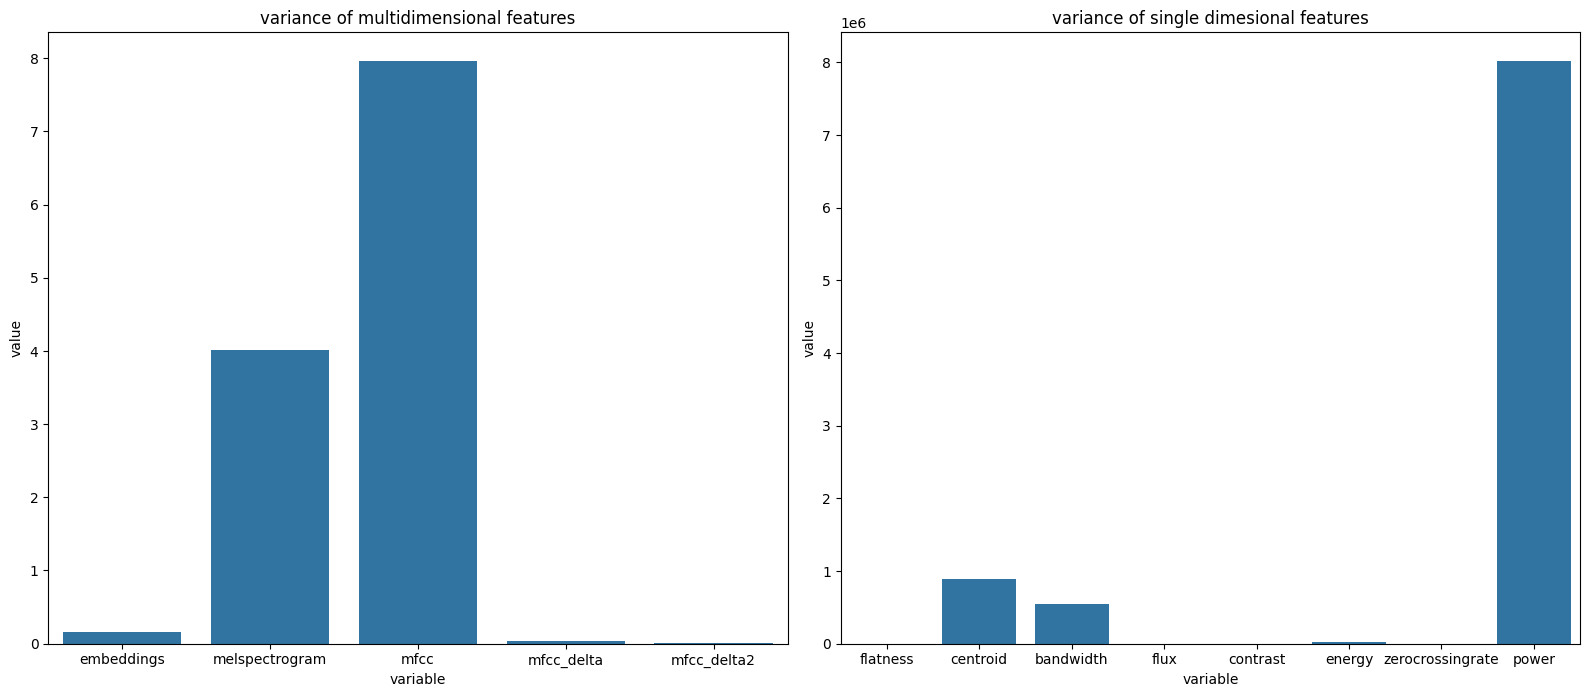

In [28]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
plot_df1 = var_df[["embeddings", "melspectrogram", "mfcc", "mfcc_delta", "mfcc_delta2"]].melt()
plot_df2= var_df[["flatness","centroid","bandwidth","flux","contrast","energy","zerocrossingrate","power"]].melt()
sns.barplot(data=plot_df1,x="variable",y="value",ax=ax[0])
sns.barplot(data=plot_df2,x="variable",y="value",ax=ax[1])
plt.tight_layout()
ax[0].set_title("variance of multidimensional features")
ax[1].set_title("variance of single dimesional features")

<Axes: >

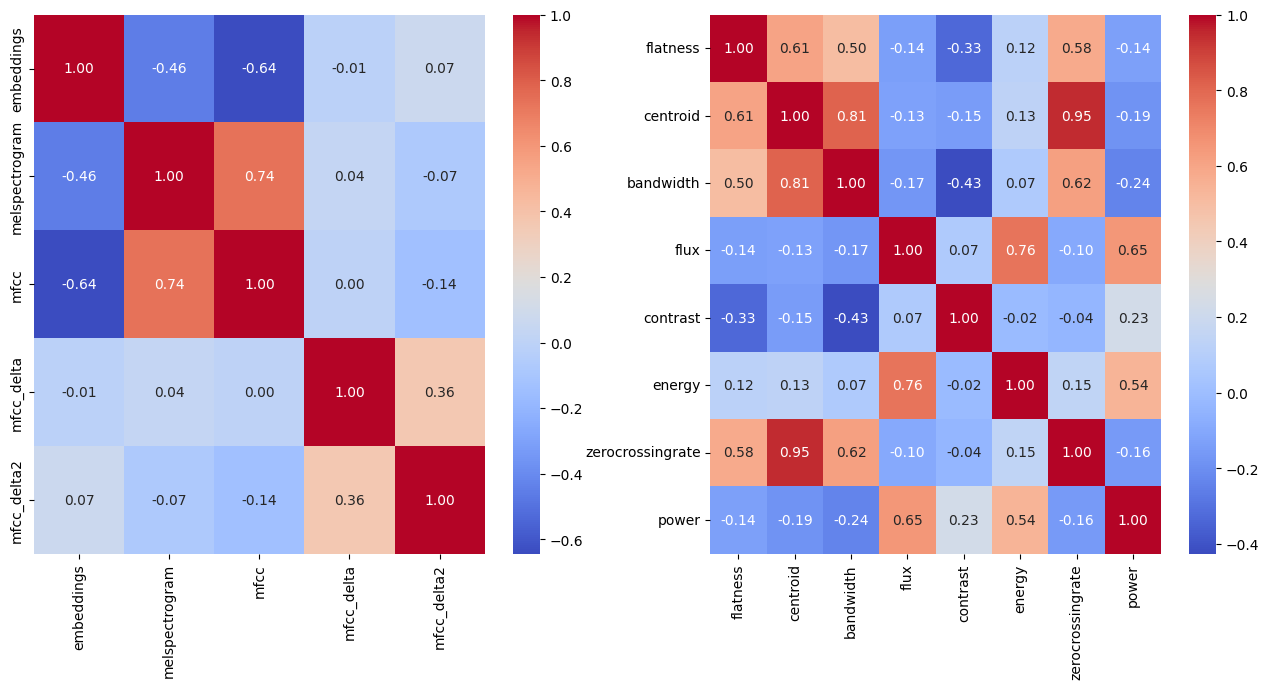

In [29]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
selected= ["embeddings","melspectrogram","mfcc","mfcc_delta","mfcc_delta2"]
s = ["flatness","centroid","bandwidth","flux","contrast","energy","zerocrossingrate","power"]
sns.heatmap(corr_matrix.loc[selected, selected], annot=True, cmap='coolwarm', fmt=".2f",ax=ax[0])
sns.heatmap(corr_matrix.loc[s, s], annot=True, cmap='coolwarm', fmt=".2f",ax=ax[1])

copy answer from task 3 of dataexploration since the plots are "identical"

**Taks 1c**

cluster the data with the two features with the highest variance while only labeling(color labeling) 2-4 chosen classes to check if they form tight clusters 

In [30]:
mfcc_features = {}

for idx, row in meta_df.iterrows():
    file_name = f"{row.get('filename', idx)}".replace('.mp3', '.npz')
    path_to_feature_file = os.path.join(AUDIO_FEATURE_FOLDER, file_name)
    
    features = np.load(path_to_feature_file)["mfcc"]
    mfcc_features[idx] = features
print("Number of feature files:", len(mfcc_features))

Number of feature files: 8230


In [31]:
melspectrogram_features = {}

for file, in zip(meta_df["filename"]):
    file_name = file.replace("mp3", "npz")
    path_to_feature_file = os.path.join(AUDIO_FEATURE_FOLDER, file_name)
    
    features = np.load(path_to_feature_file)["melspectrogram"]
    melspectrogram_features[file] = features
print("Number of feature files:", len(melspectrogram_features))

Number of feature files: 8230


In [32]:
import math
from sklearn.preprocessing import StandardScaler
def get_features_of_annotation(
    onset: float, 
    offset: float, 
    audio_features: np.ndarray, 

) -> np.ndarray:
    s= StandardScaler()
    RESOLUTION = 0.12 # temporal resolution of the features is 120 ms
    start_idx = math.floor(onset / RESOLUTION)
    offset_idx = math.ceil(offset / RESOLUTION)
    
    audio_features = audio_features[start_idx:offset_idx, :]
    
    audio_features = s.fit_transform(audio_features)    
    return audio_features.mean(axis=0)
#used code to extract mean mfcc value across all time frames  for each annotated region and ignored the silent regions since they have no corresponding annotations 

In [ ]:
import numpy as np
from tqdm import tqdm  # For progress tracking

def safe_feature_extraction(df, feature_dict, feature_length):
    """Safely create feature matrix with error handling"""
    X = np.zeros((len(df), feature_length))
    failed_indices = []
    
    for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            features = get_features_of_annotation(
                row['onset'], 
                row['offset'], 
                feature_dict[row['filename']]
            )
            if len(features) == feature_length:  # Validate shape
                X[i] = features
            else:
                failed_indices.append(i)
        except Exception as e:
            failed_indices.append(i)
            # Uncomment for debugging:
            # print(f"Error on row {i} ({row['filename']}): {str(e)}")
    
    if failed_indices:
        print(f"\nWarning: Failed to process {len(failed_indices)}/{len(df)} samples")
    return X

# Initialize matrices with validation
try:
    print("Creating MFCC features...")
    X1 = safe_feature_extraction(an_df, mfcc_features, 32)
    
    print("\nCreating Mel features...")
    X2 = safe_feature_extraction(an_df, melspectrogram_features, 64)
    
    print("\nFeature matrices created:")
    print(f"MFCC shape: {X1.shape} ({(X1 != 0).all(axis=1).sum()} valid rows)")
    print(f"Mel shape: {X2.shape} ({(X2 != 0).all(axis=1).sum()} valid rows)")

except MemoryError:
    print("CRITICAL ERROR: Out of memory! Try:")
    print("1. Reducing batch size")
    print("2. Using float32 instead of float64 (np.zeros(..., dtype=np.float32))")
except Exception as e:
    print(f"Unexpected error: {str(e)}")

Creating MFCC features...


  0%|          | 0/27552 [00:00<?, ?it/s]

100%|██████████| 27552/27552 [00:00<00:00, 41894.28it/s]




Creating Mel features...


100%|██████████| 27552/27552 [00:19<00:00, 1405.84it/s]


Feature matrices created:
MFCC shape: (27552, 32) (0 valid rows)
Mel shape: (27552, 64) (1487 valid rows)


: 

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X1_tsne = tsne.fit_transform(X1)
#X2_tsne = tsne.fit_transform(X2)
# perform tsne for vis -> since we cant vis a matrix in 2D!!!!

C:\Users\jeron\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\jeron\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jeron\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Program Files\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwar

In [ ]:
an_df["hue_label"] = an_df["labels"].apply(lambda x: "Speech_car" if x in ["Speech", "Car"] else False)

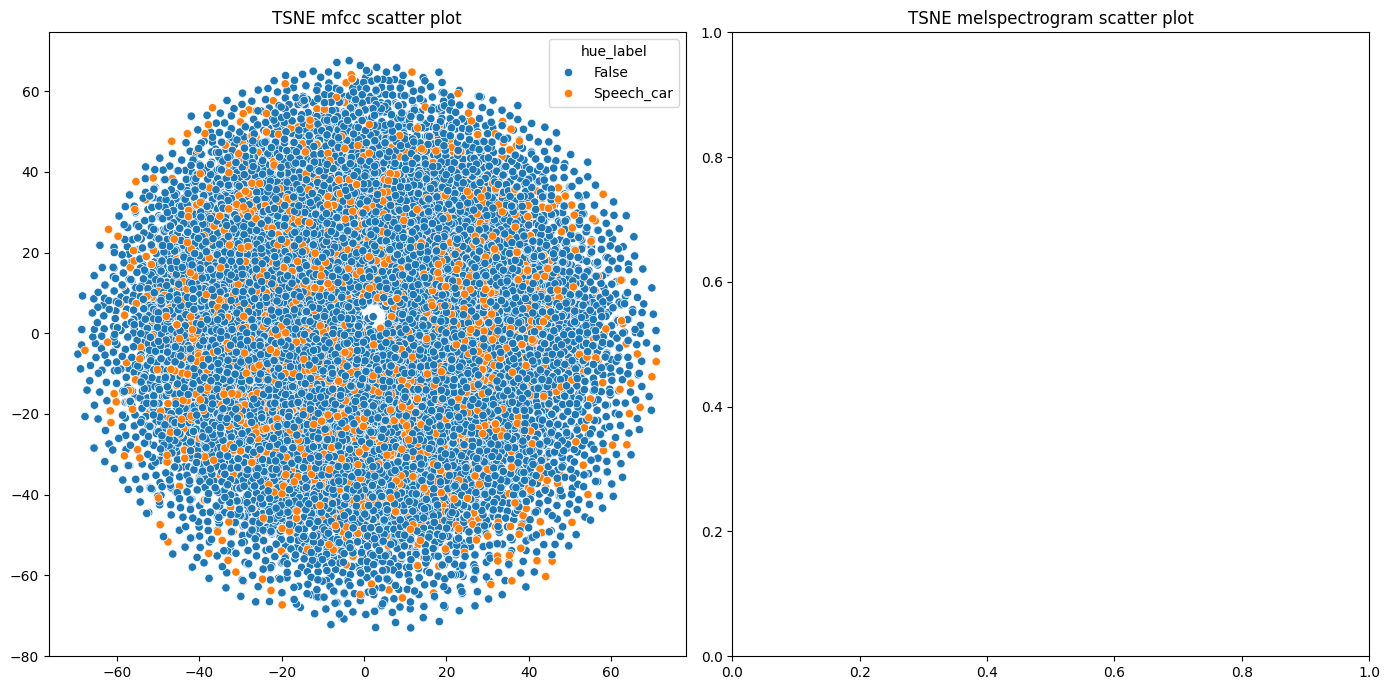

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,7))
sns.scatterplot(x=X1_tsne[:,0],y=X1_tsne[:,1],hue=an_df["hue_label"],ax=ax[0],legend=True)
#sns.scatterplot(x=X2_tsne[:,0],y=X2_tsne[:,1],hue=an_df["categories"][""],ax=ax[1],legend=True)
ax[0].set_title("TSNE mfcc scatter plot")
ax[1].set_title("TSNE melspectrogram scatter plot")
plt.tight_layout()


#assign colors to samples using "dog or cat" column to check if they form tight clusters in the mfcc feature space 